In [1]:
import numpy as np
import pandas as pd
import random
import bisect
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.style.use('ggplot')
np.random.seed(37)
random.seed(37)

class CdfCurve:
    def __init__(self, c, n_samples=10_000):
        self.__c = CdfCurve.to_cdf(CdfCurve.generate_samples(c, n_samples))
        
    def get_sample(self, n_samples=10_000):
        return CdfCurve.generate_samples(self.__c, n_samples)
    
    def sample_in(self, n_samples=10_000, lhs=0.0, rhs=1.0):
        c = list(self.__c.values)
        v = list(self.__c.index)
        
        samples = []
        
        while len(samples) < n_samples:
            while True:
                p = np.random.random(size=1)
                if lhs < p <= rhs:
                    index = bisect.bisect_left(c, p)
                    samples.append(v[index])
                    break
                    
        return pd.Series(samples)
    
    def get_cdf(self):
        return self.__c
    
    def get_ppf(self, p):
        return CdfCurve.ppf(self.__c.values, self.__c.index, p)
    
    @staticmethod
    def ppf(c, v, p):
        index = bisect.bisect_left(c, p)
        if index >= len(v):
            index -= 1
            
        return v[index]
    
    @staticmethod
    def generate_samples(c, n_samples=10_000):
        c, v = c.values, c.index
        s = pd.Series([CdfCurve.ppf(c, v, p) for p in np.random.random(n_samples)])
        return s
    
    @staticmethod
    def to_cdf(s):
        return (s.value_counts().sort_index() / len(s)).cumsum()
        
class GaussianMM:
    def __init__(self, gaussians, n_samples=10_000):
        self.__gaussians = gaussians
        
        self.__samples = {i: pd.Series(g.rvs(size=n_samples)) for i, g in enumerate(gaussians)}
        self.__samples['all'] = pd.concat([s for s in self.__samples.values()]).reset_index(drop=True)
        
        self.__cdfs = {i: CdfCurve.to_cdf(s) for i, s in self.__samples.items()}
        
    def get_sample(self, i='all'):
        return self.__samples[i]
    
    def get_cdf(self, i='all'):
        return self.__cdfs[i]
    
    def plot_kde(self, ax):
        for k, s in self.__samples.items():
            _ = s.plot(kind='kde', ax=ax, label=f'{k}')
            
    def plot_cdf(self, ax):
        for k, c in self.__cdfs.items():
            _ = c.plot(kind='line', ax=ax, label=f'{k}')

def plot_gmm_kde_cdf(gmm):
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    gmm.plot_kde(ax[0])
    gmm.plot_cdf(ax[1])

    _ = ax[0].legend()
    _ = ax[1].legend()

    plt.tight_layout()

def plot_gmm_cdf(gmm, cdf):
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    _ = gmm.get_sample().plot(kind='kde', ax=ax[0], label='from_gmm')
    _ = cdf.get_sample().plot(kind='kde', ax=ax[0], label='from_cdf')

    _ = gmm.get_cdf().plot(kind='line', ax=ax[1], label='from_gmm')
    _ = cdf.get_cdf().plot(kind='line', ax=ax[1], label='from_cdf')

    _ = ax[0].legend()
    _ = ax[1].legend()

    plt.tight_layout()

In [2]:
gmm = GaussianMM([norm(loc=10, scale=1), norm(loc=14, scale=2)])
cdf = CdfCurve(gmm.get_cdf('all'))

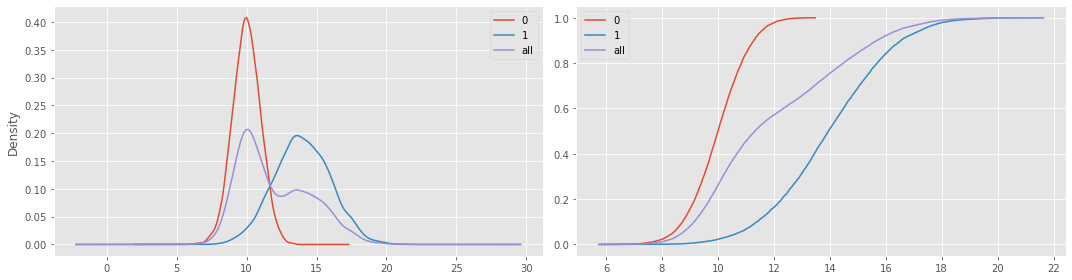

In [3]:
plot_gmm_kde_cdf(gmm)

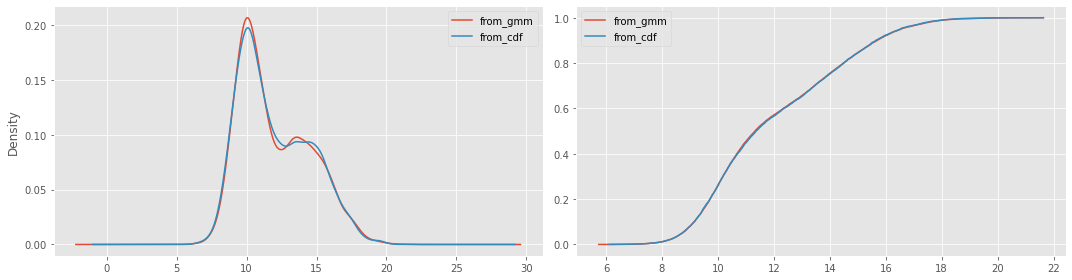

In [4]:
plot_gmm_cdf(gmm, cdf)

In [5]:
gmm = GaussianMM([norm(loc=10, scale=1), norm(loc=14, scale=2), norm(loc=5, scale=1.5)])
cdf = CdfCurve(gmm.get_cdf('all'))

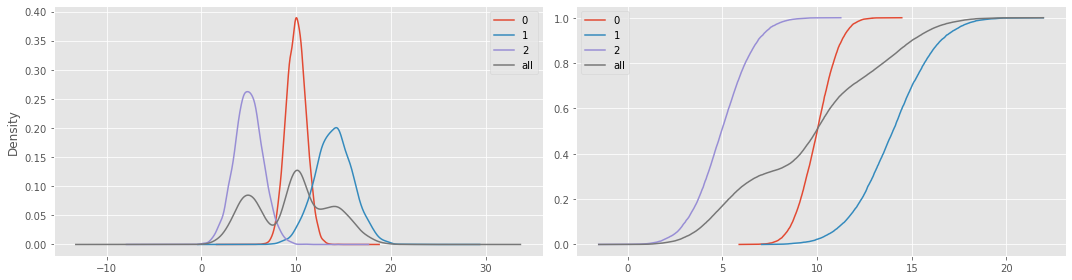

In [6]:
plot_gmm_kde_cdf(gmm)

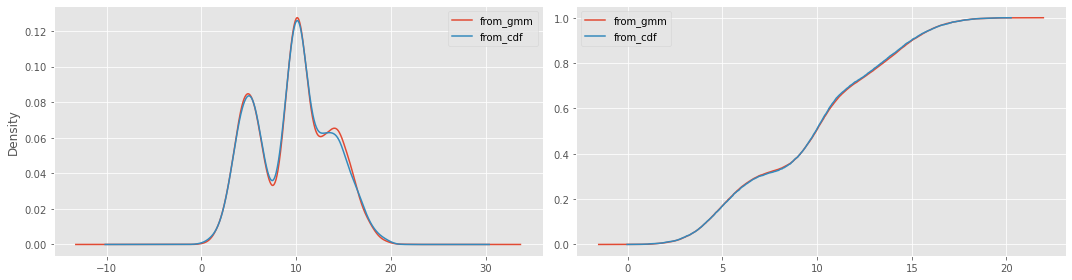

In [7]:
plot_gmm_cdf(gmm, cdf)

In [8]:
gmm1 = GaussianMM([norm(loc=10, scale=1), norm(loc=3.7, scale=2)])
gmm2 = GaussianMM([norm(loc=10, scale=1), norm(loc=14, scale=2), norm(loc=3.5, scale=1.5)])
gmm3 = GaussianMM([norm(loc=9, scale=1), norm(loc=16, scale=2), norm(loc=3.4, scale=1.5)])

cdf1 = CdfCurve(gmm1.get_cdf('all'))
cdf2 = CdfCurve(gmm2.get_cdf('all'))
cdf3 = CdfCurve(gmm3.get_cdf('all'))

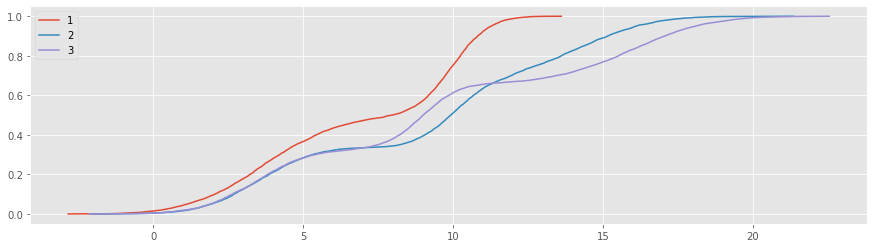

In [9]:
fig, ax = plt.subplots(figsize=(15, 4))

_ = cdf1.get_cdf().plot(kind='line', ax=ax, label='1')
_ = cdf2.get_cdf().plot(kind='line', ax=ax, label='2')
_ = cdf3.get_cdf().plot(kind='line', ax=ax, label='3')

_ = ax.legend()

In [10]:
c3 = cdf3.get_cdf()

df = pd.DataFrame({
    'c1': [cdf1.get_ppf(p) for p in c3.values],
    'c2': [cdf2.get_ppf(p) for p in c3.values],
    'c3': list(c3.index)
}, index=list(c3.values))

df.head()

,c1,c2,c3
0.0001,-2.832425,-1.995163,-2.150551
0.0002,-2.523968,-1.657571,-1.423288
0.0003,-2.334482,-1.580360,-1.396933
0.0004,-2.190718,-1.405802,-1.362672
0.0006,-1.825884,-1.222762,-1.305482


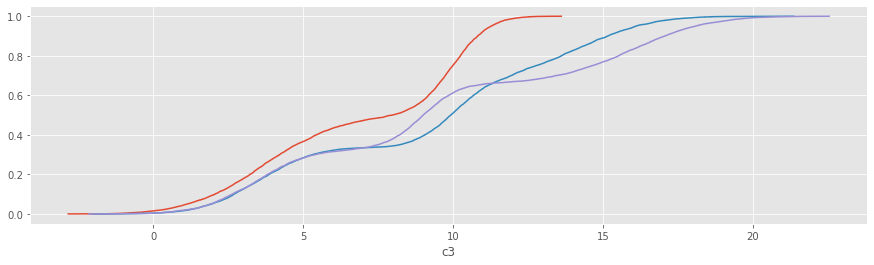

In [11]:
fig, ax = plt.subplots(figsize=(15, 4))

_ = pd.Series(df.index, index=df.c1).plot(ax=ax)
_ = pd.Series(df.index, index=df.c2).plot(ax=ax)
_ = pd.Series(df.index, index=df.c3).plot(ax=ax)

In [12]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def get_dist(d):
    d13, _ = fastdtw(d.c1, d.c3, dist=euclidean)
    d23, _ = fastdtw(d.c2, d.c3, dist=euclidean)
    
    return {'c1': d13, 'c2': d23}

delta = 0.05
index = np.arange(delta, 1.0 + delta, delta)

corr_df = map(lambda p: bisect.bisect_left(df.index, p), index)
corr_df = map(lambda i: get_dist(df.iloc[:i]), corr_df)

corr_df = pd.DataFrame(corr_df, index=index)
corr_df['w1'] = 1 - corr_df.c1 / (corr_df.c1 + corr_df.c2)
corr_df['w2'] = 1 - corr_df.c2 / (corr_df.c1 + corr_df.c2)

corr_df

,c1,c2,w1,w2
0.05,112.971469,3.502444,0.030071,0.969929
0.10,112.623934,5.410815,0.045841,0.954159
0.15,128.308285,4.454142,0.033550,0.966450
0.20,149.785664,5.857448,0.037634,0.962366
0.25,201.962091,5.906772,0.028416,0.971584
0.30,292.333067,7.073490,0.023625,0.976375
0.35,813.200013,53.082138,0.061276,0.938724
0.40,1549.146511,226.023941,0.127325,0.872675
0.45,1711.553391,359.200072,0.173463,0.826537
0.50,591.235907,460.511146,0.437854,0.562146


In [13]:
n_samples = 10_000

curves = []

for c_p, r in corr_df.iterrows():
    weights = pd.Series([r.w1, r.w2])
    p_weights = weights.cumsum()
    sizes = n_samples * weights
    
    weights, p_weights, sizes = list(weights), list(p_weights), list(np.int32(np.ceil(sizes)))
    
    sample1 = cdf1.get_sample(sizes[0])
    sample2 = cdf2.get_sample(sizes[1])
    sample = pd.concat([sample1, sample2]).reset_index(drop=True)
    
    cdf = CdfCurve(CdfCurve.to_cdf(sample))
    
    curves.append({
        'c_p': c_p,
        'weights': weights,
        'p_weights': p_weights,
        'sizes': sizes,
        'cdf': cdf
    })
    
    print(c_p, weights, p_weights, sizes, sample.shape[0])

0.05 [0.030070626566761183, 0.9699293734332388] [0.030070626566761183, 1.0] [301, 9700] 10001
0.1 [0.045840861306553404, 0.9541591386934466] [0.045840861306553404, 1.0] [459, 9542] 10001
0.15000000000000002 [0.03354971953633623, 0.9664502804636638] [0.03354971953633623, 1.0] [336, 9665] 10001
0.2 [0.037633842383530514, 0.9623661576164695] [0.037633842383530514, 1.0] [377, 9624] 10001
0.25 [0.0284158553655961, 0.9715841446344039] [0.0284158553655961, 1.0] [285, 9716] 10001
0.3 [0.023625033415601848, 0.9763749665843982] [0.023625033415601848, 1.0] [237, 9764] 10001
0.35000000000000003 [0.061275807053503994, 0.938724192946496] [0.061275807053503994, 1.0] [613, 9388] 10001
0.4 [0.12732520437354122, 0.8726747956264589] [0.12732520437354122, 1.0] [1274, 8727] 10001
0.45 [0.17346346559673198, 0.826536534403268] [0.17346346559673198, 1.0] [1735, 8266] 10001
0.5 [0.4378535170724953, 0.5621464829275047] [0.4378535170724953, 1.0] [4379, 5622] 10001
0.55 [0.6748118377486829, 0.3251881622513172] [0

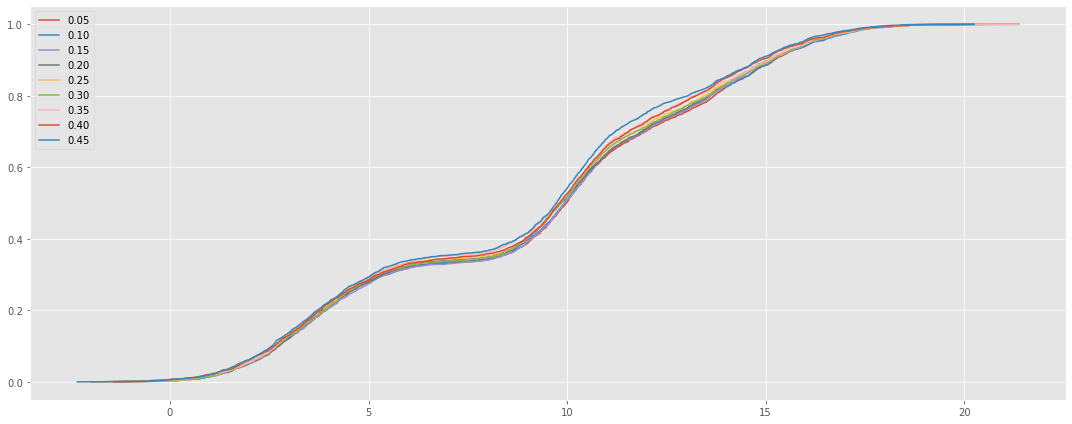

In [14]:
def plot_predicted_curves(curves):
    fig, ax = plt.subplots(figsize=(15, 6))

    for c in curves:
        cdf_curve = c['cdf']
        c_p = c['c_p']

        cdf_curve.get_cdf().plot(ax=ax, label=f'{c_p:.2f}')

    _ = ax.legend()

    plt.tight_layout()
    
plot_predicted_curves([c for c in curves if 0.0 <= c['c_p'] < 0.5])

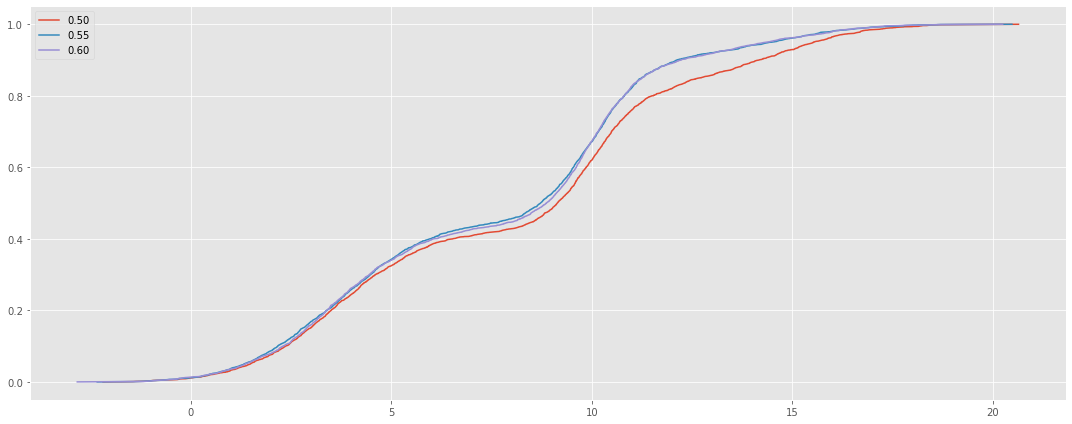

In [15]:
plot_predicted_curves([c for c in curves if 0.5 <= c['c_p'] < 0.65])

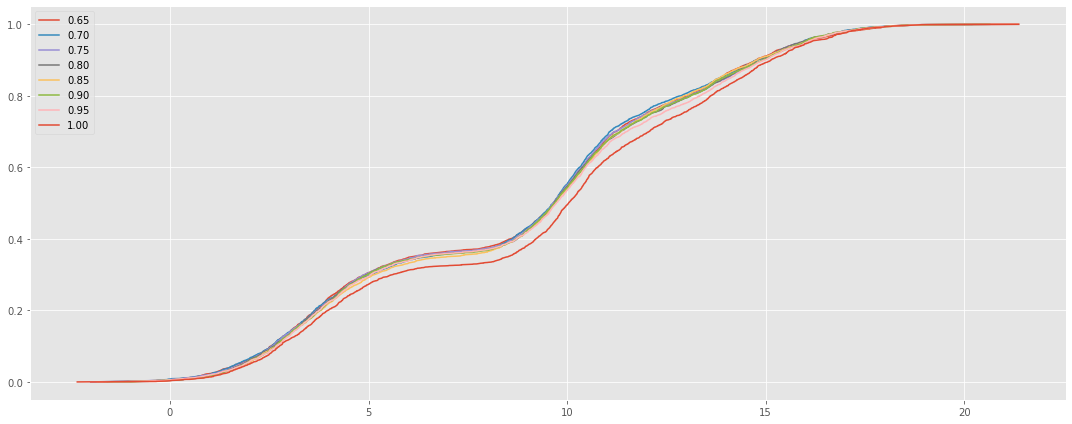

In [16]:
plot_predicted_curves([c for c in curves if 0.65 <= c['c_p'] <= 1.0])

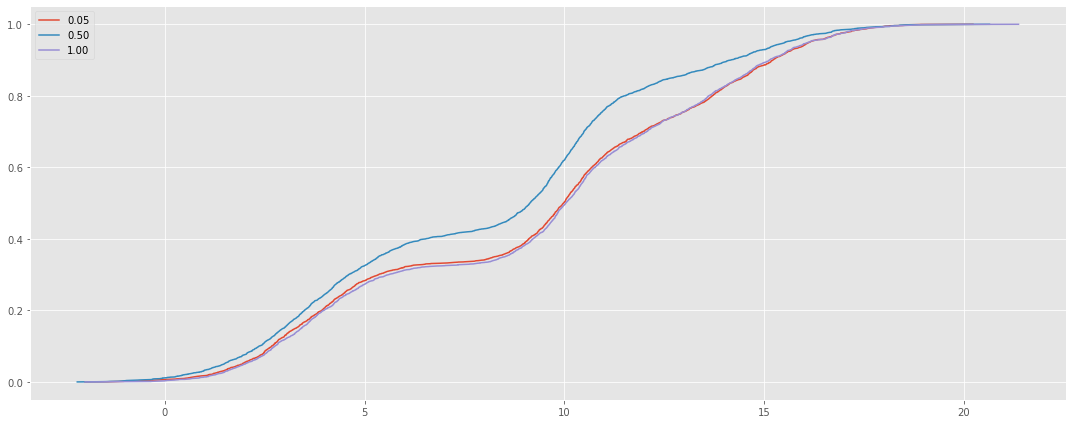

In [17]:
plot_predicted_curves([c for c in curves if c['c_p'] in [0.05, 0.5, 1.0]])

In [25]:
n_samples = 10_000

curves = []

for c_p, r in corr_df.iterrows():
    p_weights = pd.Series([r.w1, r.w2])
    c_weights = p_weights.cumsum()

    p_weights, c_weights = list(p_weights), list(c_weights)
    
    samples = []
    cdf_counts = [0, 0, 0]
    
    for i in range(n_samples):
        p = np.random.random(size=1)
        if p <= c_p:
            s = cdf3.sample_in(n_samples=1, lhs=0.0, rhs=c_p)
            cdf_counts[2] += 1
        else:
            p = np.random.random(size=1)
            j = bisect.bisect_left(c_weights, p)
            if j == 0:
                s = cdf1.sample_in(n_samples=1, lhs=c_p, rhs=1.0)
                cdf_counts[0] += 1
            else:
                s = cdf2.sample_in(n_samples=1, lhs=c_p, rhs=1.0)
                cdf_counts[1] += 1
                
        samples.extend(list(s))
    
    cdf = CdfCurve(CdfCurve.to_cdf(sample))
    
    curves.append({
        'c_p': c_p,
        'p_weights': p_weights,
        'c_weights': c_weights,
        'cdf': cdf,
        'cdf_counts': cdf_counts,
        'n_samples': len(samples)
    })
    
    print(c_p, p_weights, c_weights, cdf_counts[0], cdf_counts[1], cdf_counts[2], len(samples))

0.05 [0.030070626566761183, 0.9699293734332388] [0.030070626566761183, 1.0] 269 9228 503 10000
0.1 [0.045840861306553404, 0.9541591386934466] [0.045840861306553404, 1.0] 374 8614 1012 10000
0.15000000000000002 [0.03354971953633623, 0.9664502804636638] [0.03354971953633623, 1.0] 277 8255 1468 10000
0.2 [0.037633842383530514, 0.9623661576164695] [0.037633842383530514, 1.0] 290 7676 2034 10000
0.25 [0.0284158553655961, 0.9715841446344039] [0.0284158553655961, 1.0] 208 7274 2518 10000
0.3 [0.023625033415601848, 0.9763749665843982] [0.023625033415601848, 1.0] 163 6854 2983 10000
0.35000000000000003 [0.061275807053503994, 0.938724192946496] [0.061275807053503994, 1.0] 400 6093 3507 10000
0.4 [0.12732520437354122, 0.8726747956264589] [0.12732520437354122, 1.0] 780 5252 3968 10000
0.45 [0.17346346559673198, 0.826536534403268] [0.17346346559673198, 1.0] 975 4597 4428 10000
0.5 [0.4378535170724953, 0.5621464829275047] [0.4378535170724953, 1.0] 2260 2754 4986 10000
0.55 [0.6748118377486829, 0.325

In [27]:
sim_df = pd.DataFrame([[c['c_p']] + c['p_weights'] + c['c_weights'] + c['cdf_counts'] + [c['n_samples']]
              for c in curves], columns=['c_p', 'p1', 'p2', 'c1', 'c2', 'n1', 'n2', 'n3', 'n_samples'])
sim_df['pp1'] = sim_df.n1 / (sim_df.n1 + sim_df.n2)
sim_df['pp2'] = sim_df.n2 / (sim_df.n1 + sim_df.n2)
sim_df['pp3'] = sim_df.n3 / (sim_df.n1 + sim_df.n2 + sim_df.n3)

sim_df

,c_p,p1,p2,c1,c2,n1,n2,n3,n_samples,pp1,pp2,pp3
0,0.05,0.030071,0.969929,0.030071,1.0,269,9228,503,10000,0.028325,0.971675,0.0503
1,0.10,0.045841,0.954159,0.045841,1.0,374,8614,1012,10000,0.041611,0.958389,0.1012
2,0.15,0.033550,0.966450,0.033550,1.0,277,8255,1468,10000,0.032466,0.967534,0.1468
3,0.20,0.037634,0.962366,0.037634,1.0,290,7676,2034,10000,0.036405,0.963595,0.2034
4,0.25,0.028416,0.971584,0.028416,1.0,208,7274,2518,10000,0.027800,0.972200,0.2518
5,0.30,0.023625,0.976375,0.023625,1.0,163,6854,2983,10000,0.023229,0.976771,0.2983
6,0.35,0.061276,0.938724,0.061276,1.0,400,6093,3507,10000,0.061605,0.938395,0.3507
7,0.40,0.127325,0.872675,0.127325,1.0,780,5252,3968,10000,0.129310,0.870690,0.3968
8,0.45,0.173463,0.826537,0.173463,1.0,975,4597,4428,10000,0.174982,0.825018,0.4428
9,0.50,0.437854,0.562146,0.437854,1.0,2260,2754,4986,10000,0.450738,0.549262,0.4986


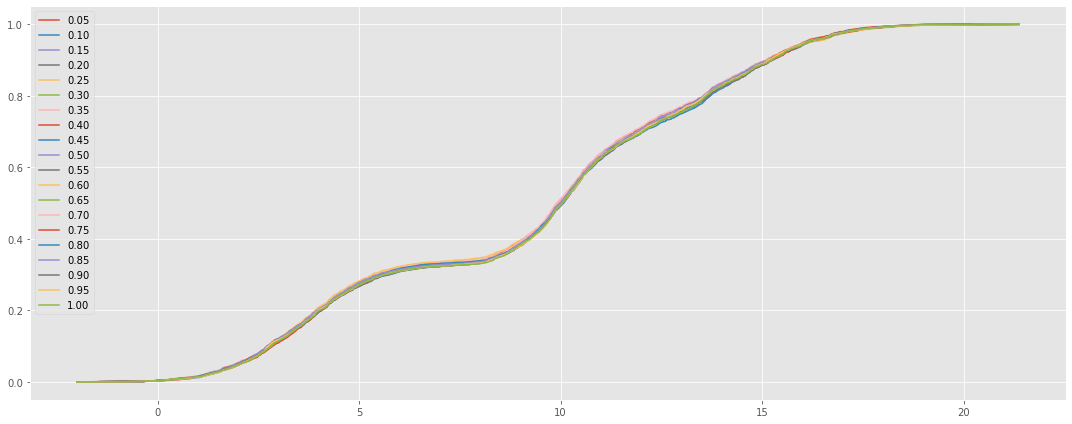

In [28]:
plot_predicted_curves(curves)

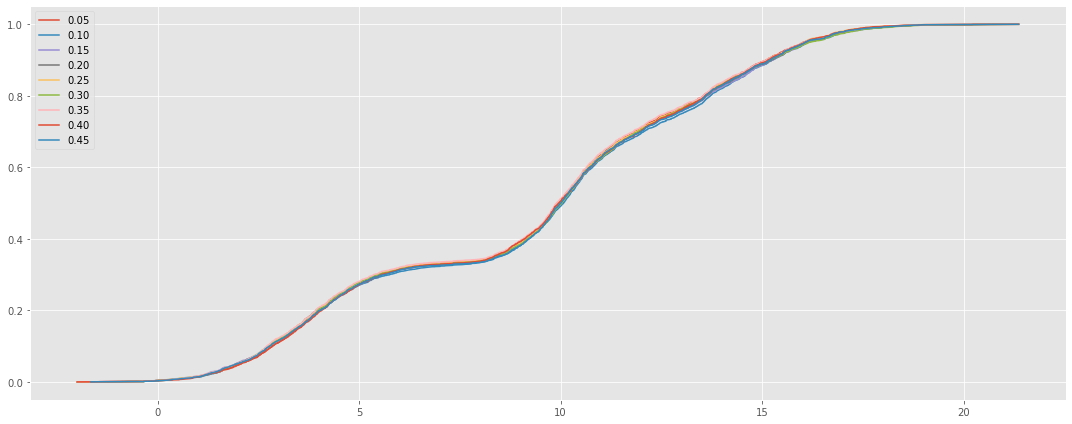

In [29]:
plot_predicted_curves([c for c in curves if 0.0 <= c['c_p'] < 0.5])

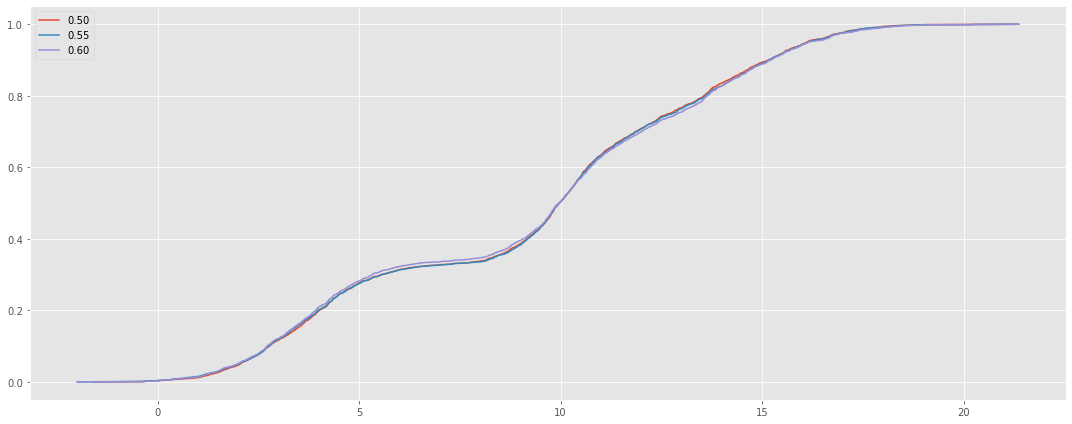

In [30]:
plot_predicted_curves([c for c in curves if 0.5 <= c['c_p'] < 0.65])

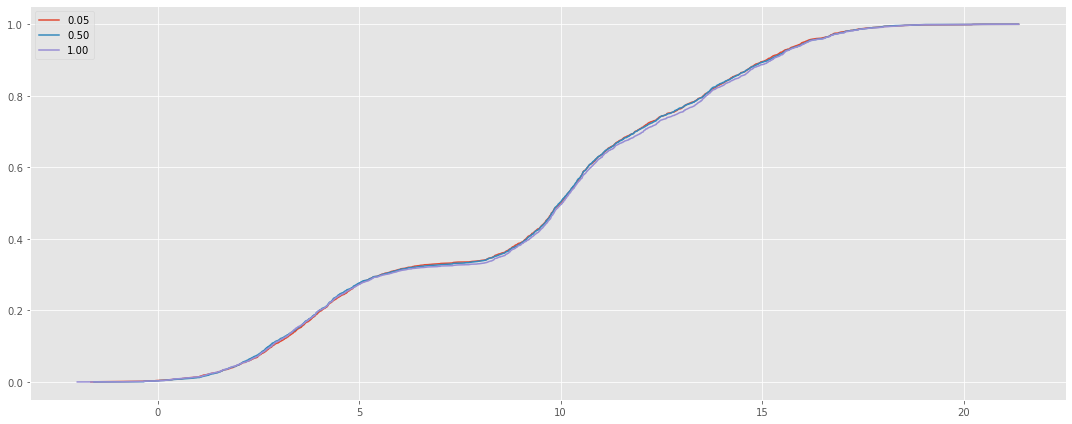

In [31]:
plot_predicted_curves([c for c in curves if c['c_p'] in [0.05, 0.5, 1.0]])